In [139]:
  import torch
  from torch import nn

  import skorch
  from skorch import NeuralNetBinaryClassifier
  from sklearn.datasets import make_classification
  from sklearn.model_selection import train_test_split

In [140]:
  import sys
  sys.path.insert(0, '../')
  
  from src.common.get_data import get_X_y_days, get_X_y_S1_S2
  from src.common.options import set_options


In [141]:
class MyBinaryClassifier(nn.Module):
    def __init__(self):
        super(MyBinaryClassifier, self).__init__()
        self.fc = nn.Linear(693, 1)

    def forward(self, X):
        return torch.sigmoid(self.fc(X))

In [173]:
  mice = ['ChRM04','JawsM15', 'JawsM18', 'ACCM03', 'ACCM04']
  tasks = ['DPA', 'DualGo', 'DualNoGo']
  days = ['first', 'last']
  
  kwargs = dict()
  kwargs = {'prescreen': None, 'pval': 0.05, 'trials': '', 'balance': 'under',
            'method': 'bootstrap', 'bolasso_pval':0.05, 'bolasso_penalty': 'l2',
            'bootstrap': True, 'n_boots': 1000,
            'preprocess': True, 'scaler_BL': 'robust', 'avg_noise':True, 'unit_var_BL':False,
            'clf':'log_loss', 'scaler': None, 'tol':0.001, 'penalty':'l2',
            'out_fold': 'stratified', 'n_out': 5,
            'in_fold': 'stratified', 'n_in': 5,
            'random_state': None, 'n_repeats': 10,
            'n_lambda': 20, 'T_WINDOW': 0.5,
            }


In [178]:
  options = set_options(**kwargs)
  options['reload'] = False
  options['data_type'] = 'raw'
  options['DCVL'] = 0
  options['task'] = 'DPA'
  X_days, y_days = get_X_y_days(**options)
  X, y = get_X_y_S1_S2(X_days, y_days, **options)

loading files from /home/leon/dual_task/dual_data/data/JawsM15


X_days (1152, 693, 84) y_days (1152, 6)
##########################################
PREPROCESSING: SCALER robust AVG MEAN False AVG NOISE True UNIT VAR False
##########################################


##########################################
DATA: FEATURES sample TASK DPA TRIALS  DAYS first LASER 0
##########################################
multiple days 0 3 0
X_S1 (48, 693, 84) X_S2 (48, 693, 84)


In [181]:
import numpy as np
from skorch import NeuralNetBinaryClassifier

X_reshape = np.swapaxes( np.swapaxes(X, 1, 2), 0, 1)
n_batches, n_samples_per_batch, n_features = X_reshape.shape

X_flat = X_reshape.reshape(-1, n_features).astype(np.float32)
y_flat = np.repeat(y, n_batches).astype(np.float32)

print(X_flat.shape, y_flat.shape)
# Instantiate skorch's classifier and set the batch_size to n_samples_per_batch
net = NeuralNetBinaryClassifier(
    MyBinaryClassifier,
    max_epochs=10,
    lr=0.1,
    # batch_size=n_samples_per_batch  # This is your actual desired batch size
)

# Fit the model with the flattened data
net.fit(X_flat, y_flat);

(8064, 693) (8064,)
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6428       0.4985        0.9880  0.0843


      2        0.6228       0.4997        0.9747  0.0800


      3        0.5946       0.4991        0.9775  0.0792


      4        0.5822       0.4947        0.9745  0.0795


      5        0.5722       0.4929        0.9683  0.0795


      6        0.5663       0.4929        0.9652  0.0795


      7        0.5617       0.4929        0.9605  0.0799


      8        0.5590       0.4916        0.9582  0.0793


      9        0.5565       0.4910        0.9552  0.0794


     10        0.5542       0.4910        0.9520  0.0794


In [187]:
# Predicting and calculating accuracy per (original) batch
# We iterate over the flattened predictions, taking slices corresponding to our original batches
y_pred_flat = net.predict(X_flat)
y_pred_batches = y_pred_flat.reshape(n_batches, -1)
print(y_pred_batches.shape)

(84, 96)


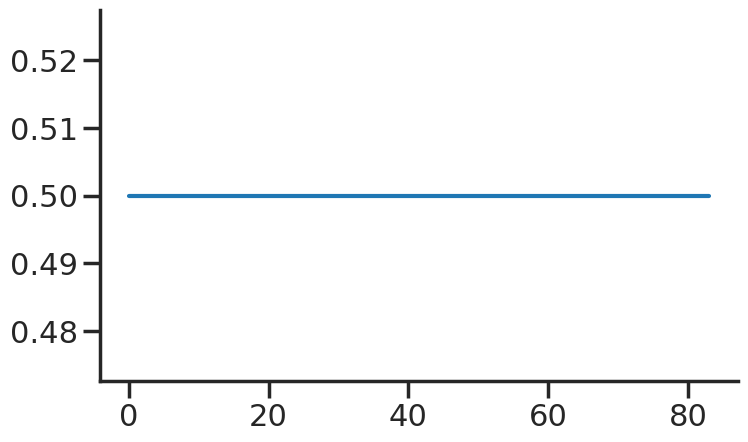

In [188]:
batch_accuracies = []
for i in range(n_batches):
    # Compute accuracy for each batch slice from the flattened array
    batch_accuracy = 1.0 - accuracy_score(y, y_pred_batches[i])
    batch_accuracies.append(batch_accuracy)

# Now batch_accuracies contains the accuracy for each of your original batches
plt.plot(batch_accuracies)
plt.show()

In [185]:
class RegularizedNet(NeuralNetBinaryClassifier):
    def __init__(self, *args, lambda1=0.01, **kwargs):
        super().__init__(*args, **kwargs)
        self.lambda1 = lambda1

    def get_loss(self, y_pred, y_true, X=None, training=False):
        loss = super().get_loss(y_pred, y_true, X=X, training=training)
        loss += self.lambda1 * sum([w.abs().sum() for w in self.module_.parameters()])
        return loss

In [192]:
# Instantiate skorch's classifier and set the batch_size to n_samples_per_batch
net = RegularizedNet(
    MyBinaryClassifier,
    max_epochs=100,
    lr=0.01,
    batch_size=32  # This is your actual desired batch size
)

# Fit the model with the flattened data
net.fit(X_flat, y_flat);


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7282       0.4997        0.9992  0.1849


      2        0.6681       0.4997        0.9700  0.1831


      3        0.6581       0.4997        0.9639  0.1855


      4        0.6549       0.4997        0.9611  0.1849


      5        0.6530       0.4997        0.9587  0.1831


      6        0.6515       0.4997        0.9563  0.1826


      7        0.6502       0.4997        0.9535  0.1815


      8        0.6491       0.4997        0.9504  0.1816


      9        0.6483       0.4997        0.9471  0.1845


     10        0.6476       0.4997        0.9437  0.1827


     11        0.6470       0.4997        0.9404  0.1834


     12        0.6465       0.4997        0.9371  0.1823


     13        0.6460       0.4997        0.9337  0.1818


     14        0.6456       0.4997        0.9304  0.1825


     15        0.6452       0.4997        0.9272  0.1822


     16        0.6448       0.4997        0.9240  0.1823


     17        0.6444       0.4997        0.9209  0.1836


     18        0.6441       0.4997        0.9178  0.1827


     19        0.6438       0.4997        0.9147  0.1824


     20        0.6436       0.4997        0.9116  0.1822


     21        0.6433       0.4997        0.9086  0.1818


     22        0.6431       0.4997        0.9056  0.1820


     23        0.6429       0.4997        0.9027  0.1878


     24        0.6427       0.4997        0.8998  0.1818


     25        0.6425       0.4997        0.8970  0.1819


     26        0.6423       0.4997        0.8942  0.1822


     27        0.6422       0.4997        0.8914  0.1818


     28        0.6420       0.4997        0.8887  0.1814


     29        0.6419       0.4997        0.8860  0.1829


     30        0.6417       0.4997        0.8834  0.1865


     31        0.6416       0.4997        0.8809  0.1820


     32        0.6415       0.4997        0.8783  0.1823


     33        0.6414       0.4997        0.8759  0.1821


     34        0.6412       0.4997        0.8734  0.1824


     35        0.6411       0.4997        0.8710  0.1841


     36        0.6411       0.4997        0.8687  0.1835


     37        0.6409       0.4997        0.8664  0.1826


     38        0.6408       0.4997        0.8641  0.1830


     39        0.6407       0.4997        0.8619  0.1822


     40        0.6407       0.4997        0.8597  0.1859


     41        0.6406       0.4997        0.8576  0.1819


     42        0.6405       0.4997        0.8555  0.1851


     43        0.6404       0.4997        0.8534  0.1827


     44        0.6403       0.4997        0.8514  0.1916


     45        0.6403       0.4997        0.8495  0.1824


     46        0.6402       0.4997        0.8475  0.1829


     47        0.6401       0.4997        0.8457  0.1828


     48        0.6401       0.4997        0.8438  0.1866


     49        0.6400       0.4997        0.8420  0.1839


     50        0.6400       0.4997        0.8402  0.1827


     51        0.6399       0.4997        0.8386  0.1846


     52        0.6399       0.4997        0.8369  0.1853


     53        0.6399       0.4997        0.8353  0.1829


     54        0.6398       0.4997        0.8337  0.1827


     55        0.6398       0.4997        0.8321  0.1829


     56        0.6397       0.4997        0.8306  0.1823


     57        0.6397       0.4997        0.8291  0.1821


     58        0.6397       0.4997        0.8277  0.1825


     59        0.6397       0.4997        0.8262  0.1831


     60        0.6396       0.4997        0.8248  0.1840


     61        0.6396       0.4997        0.8234  0.1832


     62        0.6396       0.4997        0.8221  0.1833


     63        0.6396       0.4997        0.8208  0.1862


     64        0.6396       0.4997        0.8195  0.1837


     65        0.6395       0.4997        0.8182  0.1829


     66        0.6395       0.4997        0.8170  0.1838


     67        0.6395       0.4997        0.8159  0.1830


     68        0.6396       0.4997        0.8147  0.1829


     69        0.6395       0.4997        0.8136  0.1861


     70        0.6395       0.4997        0.8124  0.1855


     71        0.6395       0.4997        0.8113  0.1842


     72        0.6395       0.4997        0.8103  0.1864


     73        0.6395       0.4997        0.8092  0.1845


     74        0.6395       0.4997        0.8082  0.1892


     75        0.6395       0.4997        0.8072  0.1852


     76        0.6395       0.4997        0.8062  0.1853


     77        0.6395       0.4997        0.8052  0.1876


     78        0.6395       0.4997        0.8043  0.1862


     79        0.6395       0.4997        0.8033  0.1891


     80        0.6395       0.4997        0.8025  0.1859


     81        0.6395       0.4997        0.8015  0.1899


     82        0.6395       0.4997        0.8006  0.1847


     83        0.6395       0.4997        0.7998  0.1840


     84        0.6395       0.4997        0.7989  0.1890


     85        0.6395       0.4997        0.7981  0.1840


     86        0.6395       0.4997        0.7973  0.1854


     87        0.6395       0.4997        0.7966  0.1844


     88        0.6395       0.4997        0.7958  0.1863


     89        0.6395       0.4997        0.7950  0.1843


     90        0.6395       0.4997        0.7943  0.1844


     91        0.6395       0.4997        0.7936  0.1846


     92        0.6395       0.4997        0.7929  0.1847


     93        0.6395       0.4997        0.7922  0.1846


     94        0.6395       0.4997        0.7915  0.1887


     95        0.6395       0.4997        0.7908  0.1844


     96        0.6395       0.4997        0.7902  0.1845


     97        0.6395       0.4997        0.7895  0.1877


     98        0.6395       0.4997        0.7889  0.1888


     99        0.6395       0.4997        0.7883  0.1847


    100        0.6395       0.4997        0.7876  0.1856
